In [ ]:
# Installing required libraries and setting up

!nvcc --version
!pip install cupy-cuda110
!git clone https://github.com/cybertronai/pytorch-sso.git
%cd pytorch-sso/
!python setup.py install

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
     |████████████████████████████████| 165.3MB 72kB/s 
Cloning into 'pytorch-sso'...
remote: Enumerating objects: 658, done.
remote: Counting objects: 100% (658/658), done.
remote: Compressing objects: 100% (364/364), done.
remote: Total 658 (delta 373), reused 550 (delta 280), pack-reused 0
Receiving objects: 100% (658/658), 15.73 MiB | 27.78 MiB/s, done.
Resolving deltas: 100% (373/373), done.
/content/pytorch-sso
running install
running bdist_egg
running egg_info
creating torchsso.egg-info
writing torchsso.egg-info/PKG-INFO
writing dependency_links to torchsso.egg-info/dependency_links.txt
writing requirements to torchsso.egg-info/requires.txt
writing top-level names to torchsso.egg-info/top_level.txt
writing manifest file 'torchsso.egg-info/SOURCES.txt'
adding license file 'LICE

In [ ]:
# Importing required libraries

import os
import argparse
import inspect

import imageio
import pickle

# Libraries for building neural nets
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchsso

# Libraries for datasets and pre-processing
from sklearn.datasets import make_blobs,make_moons,make_circles,make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# using GPU if available
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [ ]:
# Defining a Neural Network

class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=None, act_func="relu"):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        if output_size is not None:
            self.output_size = output_size
            self.squeeze_output = False
        else:
            self.output_size = 1
            self.squeeze_output = True

        # Set activation function
        if act_func == "relu":
            self.act = F.relu
        elif act_func == "tanh":
            self.act = F.tanh
        elif act_func == "sigmoid":
            self.act = torch.sigmoid
        else:
            raise ValueError(f'Invalid activation function: {act_func}')

        # Define layers
        if hidden_sizes is None:
            # Linear model
            self.hidden_layers = []
            self.output_layer = nn.Linear(self.input_size, self.output_size)
        else:
            # Neural network
            features = zip([self.input_size] + hidden_sizes[:-1], hidden_sizes)
            self.hidden_layers = nn.ModuleList([nn.Linear(in_features, out_features) for in_features, out_features in features])
            self.output_layer = nn.Linear(hidden_sizes[-1], self.output_size)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        h = x
        for layer in self.hidden_layers:
            h = self.act(layer(h))

        out = self.output_layer(h)
        if self.squeeze_output:
            out = torch.squeeze(out).view([-1])

        return out

In [ ]:
# Function to calculate entropy, which is used as an uncertainity measure of the model
def get_entropy(prob: torch.Tensor):
    entropy = - prob * torch.log(prob) - (1 - prob) * torch.log(1 - prob)
    entropy[entropy != entropy] = 0  # nan to zero
    entropy = entropy.detach().cpu().numpy()

    return entropy

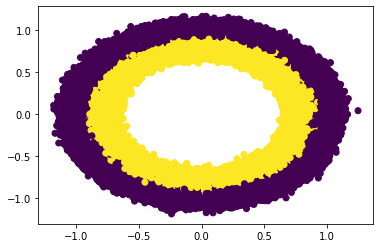

In [ ]:
# Generating a dataset with non-linear decision boundary
X,y = make_circles(n_samples=150000, shuffle=True, noise=0.05, random_state=2021)
plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

In [ ]:
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=2021)
X = X_train
y = y_train
print(X.shape, y.shape)
print(y)

(100000, 2) (100000,)
[1 0 1 ... 0 0 0]


In [ ]:
# Required Params
batch_size = 64
epochs = 50
n_samples_for_mcplot=10000
plot_interval=10
n = 10000
n_initial = 500
n_addition = 150
n_iter=(n-n_initial)//n_addition//2

In [ ]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = 0.05
xx, yy = np.meshgrid(np.arange(x_min-2, x_max+2, h),
                        np.arange(y_min-2, y_max+2, h))
data_meshgrid = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float).to(device)

X_tensor = torch.from_numpy(X).type(torch.float)
y_tensor = torch.from_numpy(y).type(torch.float)
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [ ]:
# Creating two models of neural nets to test VOGN and ADAM performances
model_kwargs = dict(input_size=2, output_size=None, hidden_sizes=[16,8,4,2])

model1 = MLP(**model_kwargs)
model1 = model1.to(device)
print(model1)
optimizer1 = torch.optim.Adam(model1.parameters())

model2 = pickle.loads(pickle.dumps(model1))  # create a clone
model2 = model2.to(device)
print(model2)
optimizer2 = torchsso.optim.VOGN(model2, dataset_size=len(train_loader.dataset))

MLP(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
    (3): Linear(in_features=4, out_features=2, bias=True)
  )
  (output_layer): Linear(in_features=2, out_features=1, bias=True)
)
MLP(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
    (3): Linear(in_features=4, out_features=2, bias=True)
  )
  (output_layer): Linear(in_features=2, out_features=1, bias=True)
)


In [ ]:
# Defining pandas dataframe of the dataset
X_pool = pd.DataFrame({'F1': X[:, 0], 'F2': X[:, 1]})
y_pool = pd.DataFrame({'Target' :y[:]})

In [ ]:
# Function to get tensor iterator (used by torch model) from numpy array
def get_tensor_iterator(X,y,batch_size=32):
  X_tensor = torch.from_numpy(X).type(torch.float)
  y_tensor = torch.from_numpy(y).type(torch.float)
  train_dataset = TensorDataset(X_tensor, y_tensor)
  train_loader = DataLoader(train_dataset, batch_size=batch_size)
  return train_loader

In [ ]:
# Function to train the model with given optimization algorithm and datapoints
def train_model(train_itr,epochs=6,algo="vogn"):
  
  for epoch in range(epochs):

    model1.train()
    model2.train()
    
    if algo == "adam":   
    
      for data, target in train_itr:
          data, target = data.to(device), target.to(device)
          def closure1():
              optimizer1.zero_grad()
              output = model1(data).view(target.shape)
              loss = F.binary_cross_entropy_with_logits(output, target)
              loss.backward()
              return loss
          loss1 = optimizer1.step(closure1)

    if algo == "vogn":

      for data, target in train_itr:
          data, target = data.to(device), target.to(device)
          def closure2():
              optimizer2.zero_grad()
              output = model2(data).view(target.shape)
              loss = F.binary_cross_entropy_with_logits(output, target)
              loss.backward()
              return loss, output
          loss2, _ = optimizer2.step(closure2)


In [ ]:
# Function which returns the indices of points which has high entropy
def get_high_entropy_indices(train_inds, X, y, algo='vogn'):
  X_c = X.copy()
  X_c = X_c[~X_c.index.isin(list(train_inds.keys()))]
  inds = list(X_c.index.values)

  X_samples = X_c.to_numpy()
  X_samples = torch.from_numpy(X_samples).type(torch.float)

  if(algo=='vogn'):
    model2.eval()
    prob = optimizer2.prediction(X_samples)
  elif(algo=='adam'):
    model1.eval()
    prob = torch.sigmoid(model1(X_samples))
  else:
    print('Invalid Algorithm')
    return -1

  entropy = get_entropy(prob)

  ind_pair_arr = []
  for i in range(len(entropy)):
    ind_pair_arr.append([ entropy[i],inds[i] ]) 
  ind_pair_arr.sort(reverse=True)
  
  high_ent_inds = []
  for i in range(n_addition):
    high_ent_inds.append(ind_pair_arr[i][1])

  return high_ent_inds

VOGN train Data Size:  (500, 2)
ADAM train Data Size:  (500, 2)

Epoch Done
Acc. of VOGN =  0.5003

Epoch Done
Acc. of ADAM =  0.5003


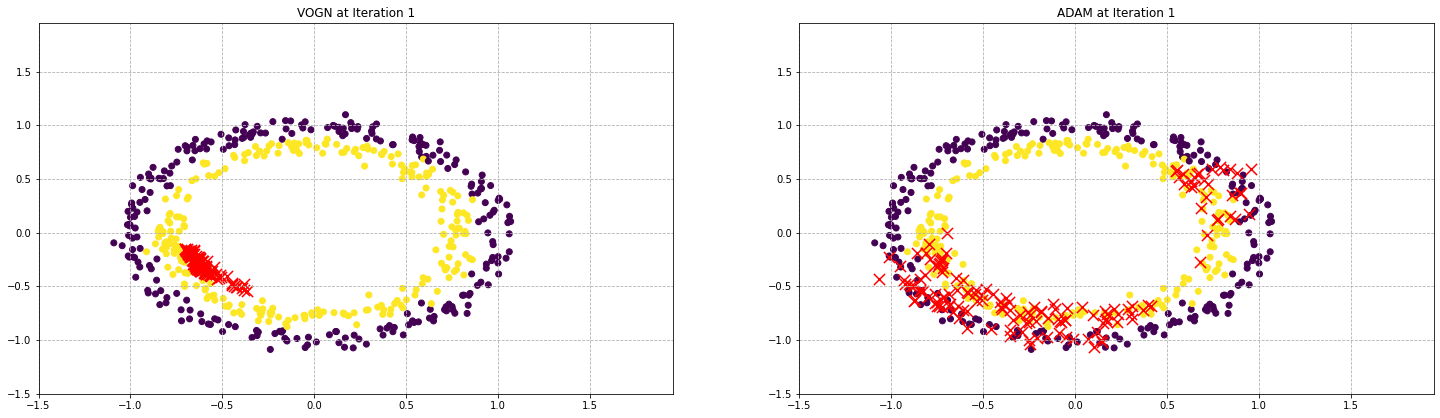

VOGN train Data Size:  (650, 2)
ADAM train Data Size:  (650, 2)

Epoch Done
Acc. of VOGN =  0.8951

Epoch Done
Acc. of ADAM =  0.5003


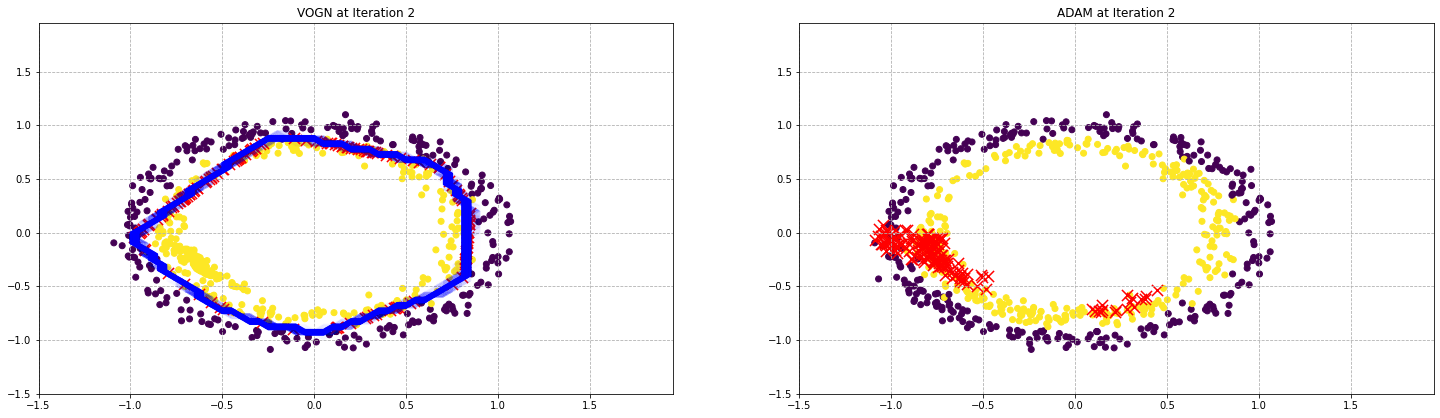

VOGN train Data Size:  (800, 2)
ADAM train Data Size:  (800, 2)

Epoch Done
Acc. of VOGN =  0.9458

Epoch Done
Acc. of ADAM =  0.69794


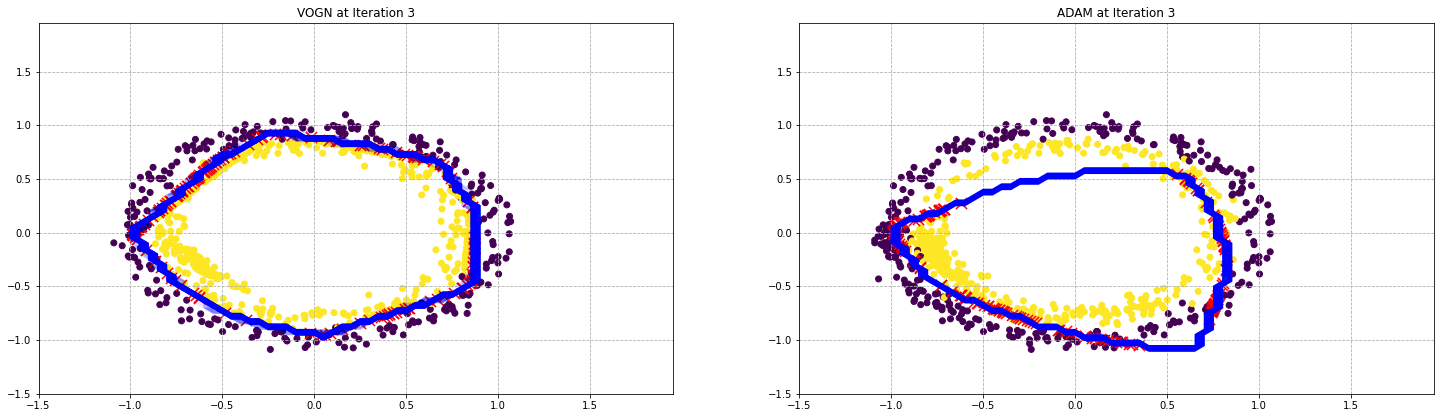

VOGN train Data Size:  (950, 2)
ADAM train Data Size:  (950, 2)

Epoch Done
Acc. of VOGN =  0.95706

Epoch Done
Acc. of ADAM =  0.88286


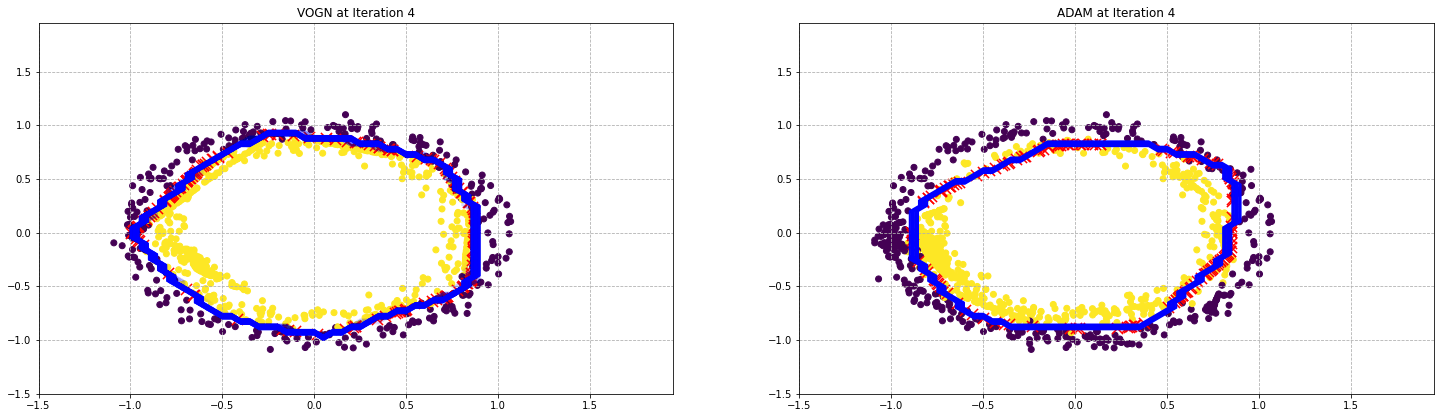

VOGN train Data Size:  (1100, 2)
ADAM train Data Size:  (1100, 2)

Epoch Done
Acc. of VOGN =  0.96102

Epoch Done
Acc. of ADAM =  0.96318


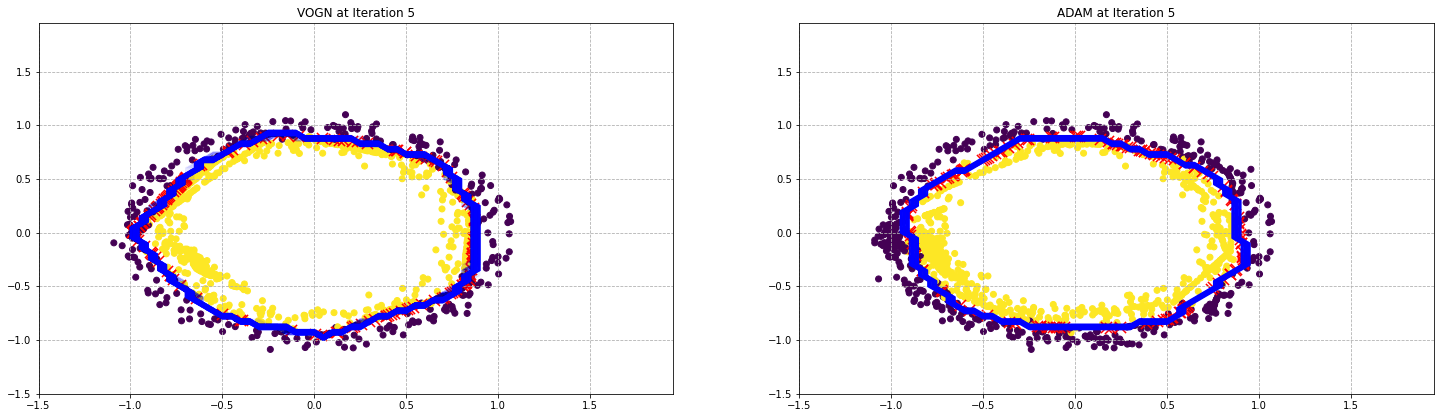

VOGN train Data Size:  (1250, 2)
ADAM train Data Size:  (1250, 2)

Epoch Done
Acc. of VOGN =  0.9634

Epoch Done
Acc. of ADAM =  0.97088


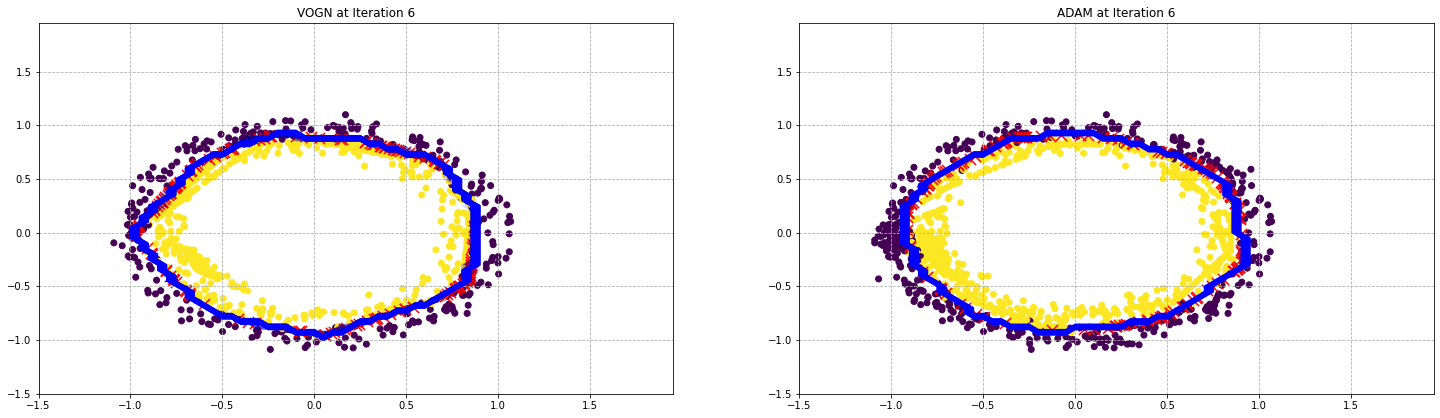

VOGN train Data Size:  (1400, 2)
ADAM train Data Size:  (1400, 2)

Epoch Done
Acc. of VOGN =  0.9649

Epoch Done
Acc. of ADAM =  0.9641


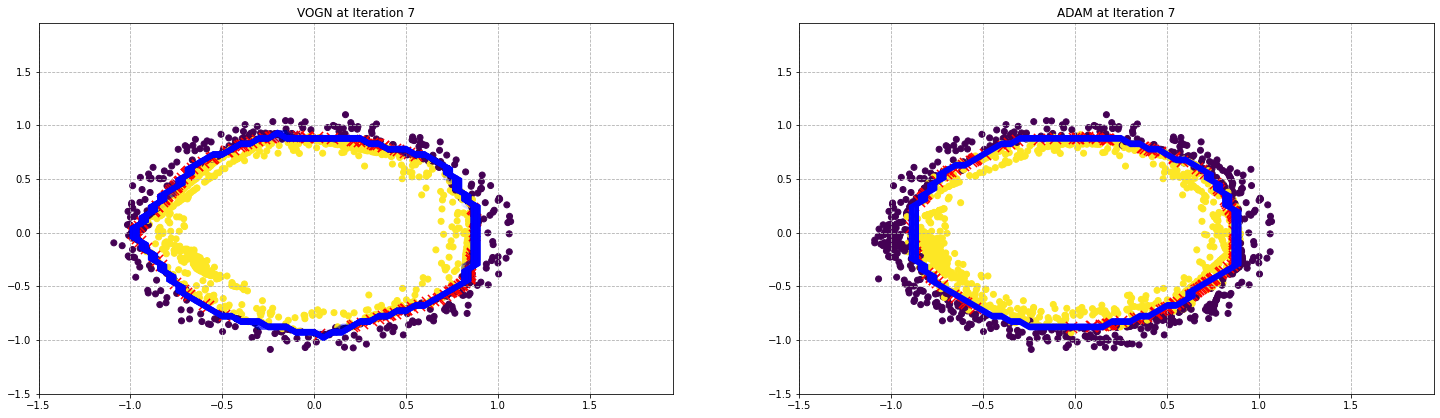

VOGN train Data Size:  (1550, 2)
ADAM train Data Size:  (1550, 2)

Epoch Done
Acc. of VOGN =  0.9661

Epoch Done
Acc. of ADAM =  0.97238


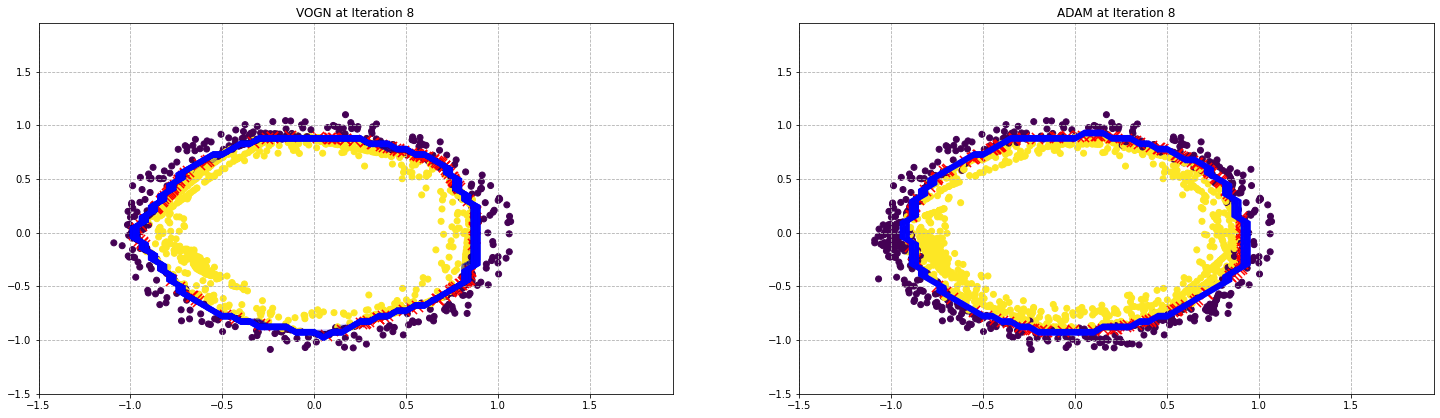

VOGN train Data Size:  (1700, 2)
ADAM train Data Size:  (1700, 2)

Epoch Done
Acc. of VOGN =  0.96702

Epoch Done
Acc. of ADAM =  0.97518


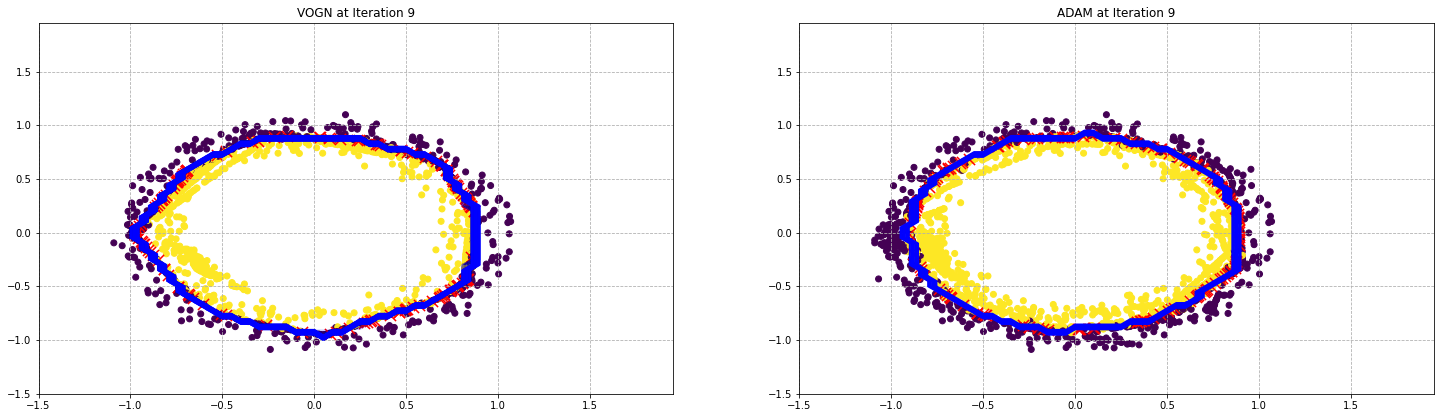

VOGN train Data Size:  (1850, 2)
ADAM train Data Size:  (1850, 2)

Epoch Done
Acc. of VOGN =  0.9682

Epoch Done
Acc. of ADAM =  0.9759


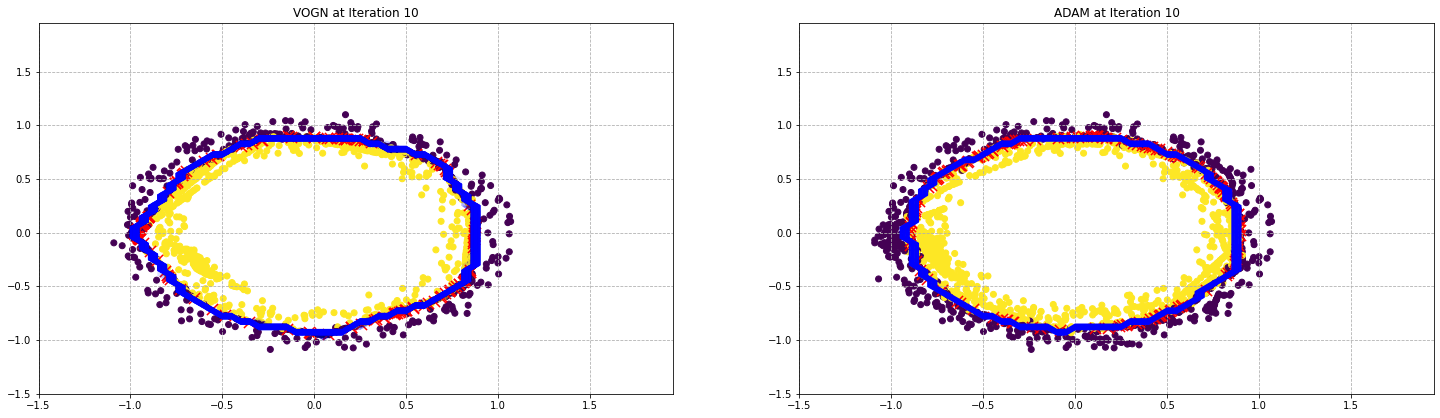

VOGN train Data Size:  (2000, 2)
ADAM train Data Size:  (2000, 2)

Epoch Done
Acc. of VOGN =  0.96902

Epoch Done
Acc. of ADAM =  0.97562


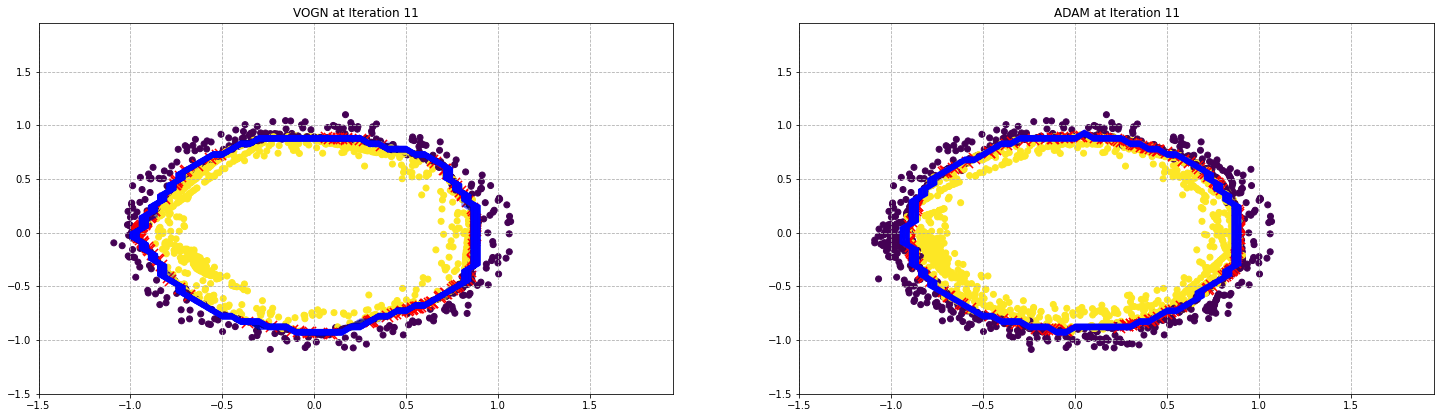

VOGN train Data Size:  (2150, 2)
ADAM train Data Size:  (2150, 2)

Epoch Done
Acc. of VOGN =  0.96958

Epoch Done
Acc. of ADAM =  0.97552


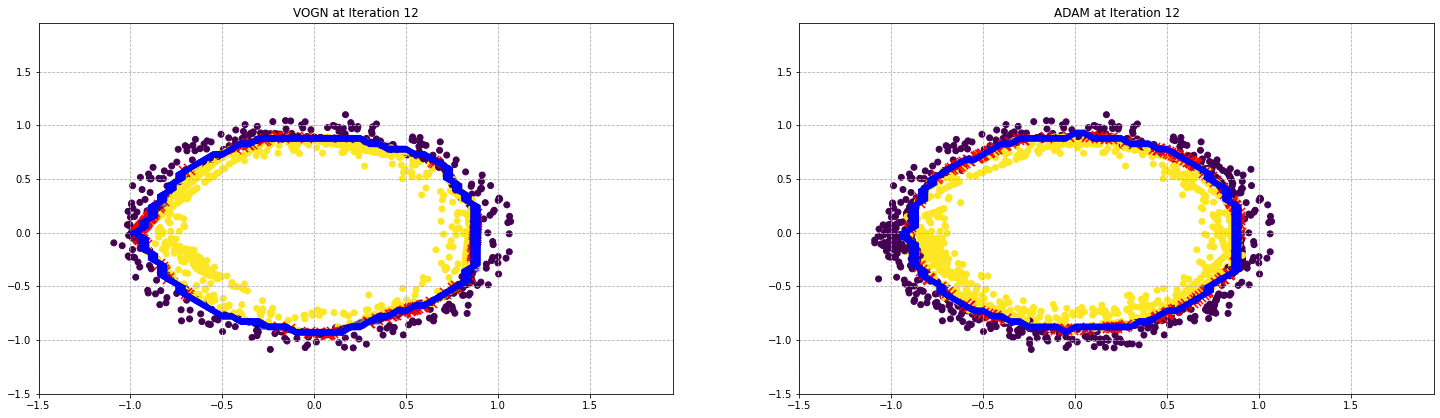

VOGN train Data Size:  (2300, 2)
ADAM train Data Size:  (2300, 2)

Epoch Done
Acc. of VOGN =  0.96998

Epoch Done
Acc. of ADAM =  0.9752


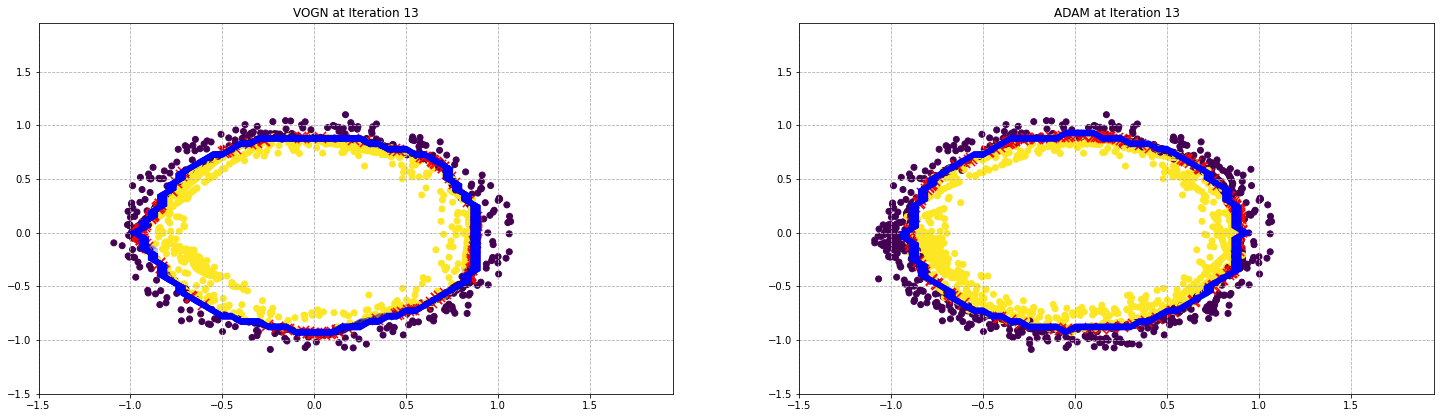

VOGN train Data Size:  (2450, 2)
ADAM train Data Size:  (2450, 2)

Epoch Done
Acc. of VOGN =  0.9706

Epoch Done
Acc. of ADAM =  0.97546


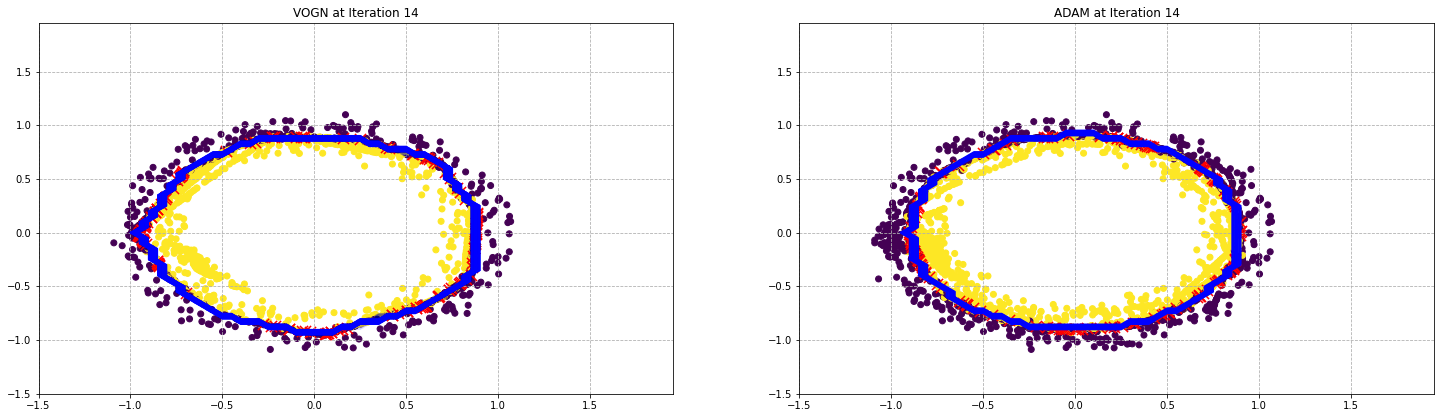

VOGN train Data Size:  (2600, 2)
ADAM train Data Size:  (2600, 2)

Epoch Done
Acc. of VOGN =  0.97104

Epoch Done
Acc. of ADAM =  0.9749


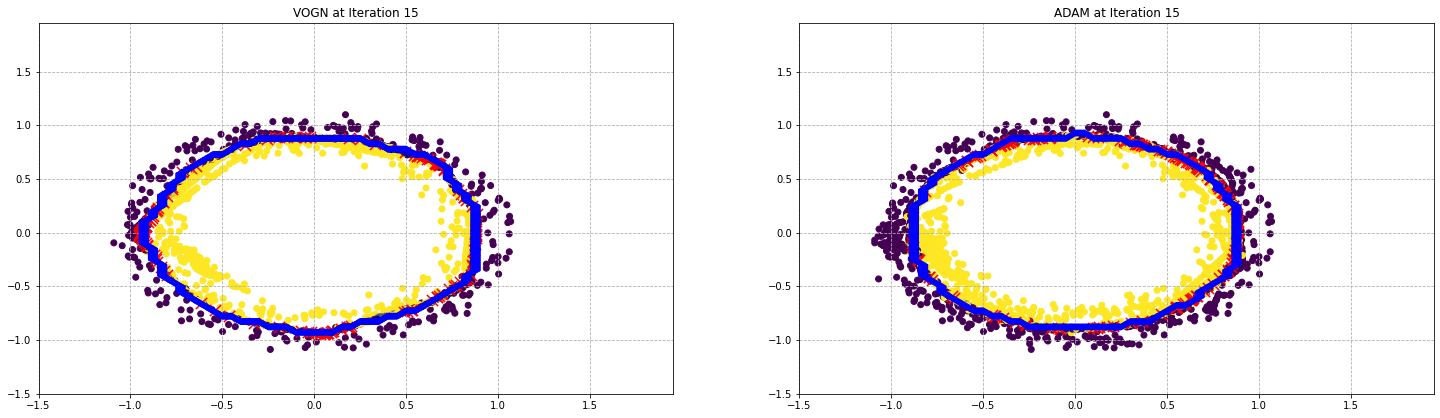

In [ ]:
# Active Learning implementation
train_inds_vogn = {} 
train_inds_adam = {}

acc_vogn = []
acc_adam = []
points_size = []

inds = list(range(n))  #n = 10k
np.random.seed(19)
np.random.shuffle(inds)   # [1,2,3,4...1000] ---> random shuffling

for i in range(n_initial):
  train_inds_vogn[inds[i]] = True
  train_inds_adam[inds[i]] = True

for itr in range(n_iter//2):
  X_train_vogn = X_pool.iloc[list(train_inds_vogn.keys())].to_numpy()
  y_train_vogn = y_pool.iloc[list(train_inds_vogn.keys())].to_numpy()

  X_train_adam = X_pool.iloc[list(train_inds_adam.keys())].to_numpy()
  y_train_adam = y_pool.iloc[list(train_inds_adam.keys())].to_numpy()

  print("VOGN train Data Size: ", X_train_vogn.shape)
  print("ADAM train Data Size: ", X_train_adam.shape)

  points_size.append(X_train_vogn.shape[0])  
  
  train_itr_vogn = get_tensor_iterator(X_train_vogn, y_train_vogn)
  train_itr_adam = get_tensor_iterator(X_train_adam, y_train_adam)

  train_model(train_itr_vogn, 6, "vogn")
  train_model(train_itr_adam, 6, "adam")

  high_entropy_inds_vogn = get_high_entropy_indices(train_inds=train_inds_vogn, X=X_pool, y=y_pool, algo = "vogn")
  high_entropy_inds_adam = get_high_entropy_indices(train_inds=train_inds_adam, X=X_pool, y=y_pool, algo = "adam")
  

  for ind in high_entropy_inds_vogn:
    if(ind in train_inds_vogn):
      print("Not Expected ;(")
    train_inds_vogn[ind] = True

  for ind in high_entropy_inds_adam:
    if(ind in train_inds_adam):
      print("Not Expected ;(")
    train_inds_adam[ind] = True 

 
  prob_vogn = optimizer2.prediction( torch.from_numpy(X_test).type(torch.float) , mc=0)
  pred_vogn = torch.round(prob_vogn).detach().cpu().numpy()
  entropy_adam = get_entropy(prob_vogn)
  print()
  print('Epoch Done')
  acc_vogn.append(acc(pred_vogn, y_test))
  print("Acc. of VOGN = ", acc_vogn[-1]) 

  prob_adam = torch.sigmoid(model1(torch.from_numpy(X_test).type(torch.float)))
  pred_adam = torch.round(prob_adam).detach().cpu().numpy()
  entropy_adam = get_entropy(prob_adam)
  print()
  print('Epoch Done')
  acc_adam.append(acc(pred_adam, y_test))
  print("Acc. of ADAM = ",acc_adam[-1])

  fig = plt.figure(figsize=(25, 15))
  gs = fig.add_gridspec(2, 2)

  # VOGN Plot
  
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.scatter(X_train_vogn[:,0],X_train_vogn[:,1],c=y_train_vogn)
  ax1.scatter(X_pool.iloc[high_entropy_inds_vogn]['F1'], X_pool.iloc[high_entropy_inds_vogn]['F2'], c='r', marker="x", s=125)
  ax1.set_title(f'VOGN at Iteration {itr+1}')
  
  # ADAM plot
  
  ax2 = fig.add_subplot(gs[0, 1])
  ax2.scatter(X_train_adam[:,0],X_train_adam[:,1],c=y_train_adam)
  ax2.scatter(X_pool.iloc[high_entropy_inds_adam]['F1'], X_pool.iloc[high_entropy_inds_adam]['F2'], c='r', marker="x", s=125)
  ax2.set_title(f'ADAM at Iteration {itr+1}')

# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
  # x_min, x_max = X_train_adam[:, 0].min() - 1, X_train_adam[:, 0].max() + 1
  # y_min, y_max = X_train_adam[:, 1].min() - 1, X_train_adam[:, 1].max() + 1
  x_min, x_max = -1.5, 2
  y_min, y_max = -1.5, 2 
  h = 0.05
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  data_meshgrid = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float).to(device)
# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

  # Decision Boundary VOGN

  # (VOGN) get MC samples
  prob, probs = optimizer2.prediction(data_meshgrid, keep_probs=True)
  prob = prob.view(xx.shape)
  entropy = get_entropy(prob)

  probs = probs[:n_samples_for_mcplot]
  preds = [torch.round(p).detach().cpu().numpy().reshape(xx.shape) for p in probs]
  for pred in preds:
      ax1.contour(xx, yy, pred, colors=['blue'], alpha=0.01)


  # (VOGN) get mean prediction
  prob = optimizer2.prediction(data_meshgrid, mc=0).view(xx.shape)
  pred = torch.round(prob).detach().cpu().numpy()

  plot = ax1.contour(xx, yy, pred, colors=['blue'], linewidths=[2])
  plot.collections[len(plot.collections)//2].set_label('VOGN')


  # Decision Boundary ADAM
  prob = torch.sigmoid(model1(data_meshgrid)).view(xx.shape)
  entropy = get_entropy(prob)
  pred = torch.round(prob).detach().cpu().numpy()
  plot = ax2.contour(xx, yy, pred, colors=['blue'], linewidths=[2])
  plot.collections[len(plot.collections)//2].set_label('Adam')

    
  ax1.grid(linestyle='--')
  ax2.grid(linestyle='--')

  plt.show()

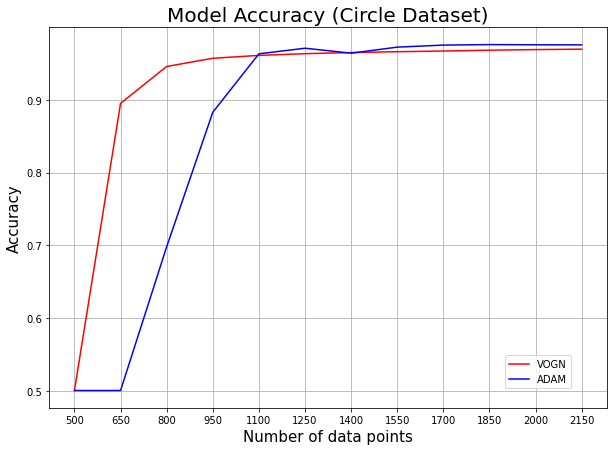

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(points_size[:12], acc_vogn[:12], 'r', label="VOGN")
plt.plot(points_size[:12], acc_adam[:12], 'b', label="ADAM")
plt.xticks(points_size[:12], points_size[:12])
plt.figlegend(loc='upper right', bbox_to_anchor=(0.8, 0.2))
plt.xlabel("Number of data points", fontSize=15)
plt.ylabel("Accuracy", fontSize=15)
plt.title("Model Accuracy (Circle Dataset)", fontSize = 20)
plt.grid()
plt.show()


